In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint

import tensorflow as tf
from tensorflow.keras import layers, Model, Sequential

In [5]:
data = pd.read_csv('Data/train.csv')
X, y = data.iloc[:, 1:].values.reshape(-1, 28, 28, 1), data.iloc[:, 0].values
y = tf.keras.utils.to_categorical(y)

In [33]:
X = X / 255

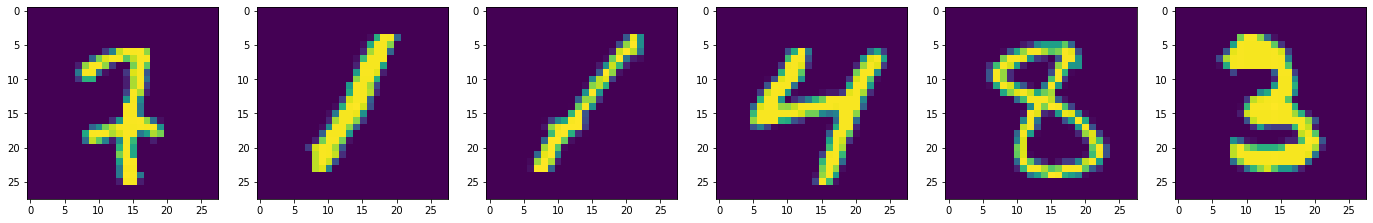

In [34]:
fig, ax = plt.subplots(figsize=(24, 6), ncols=6)

for i in range(6):
    ax[i].imshow(X[randint(0, X.shape[0])])

In [35]:
def get_model():

    data_augmentation = Sequential(
        [
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.1),
        ]
    )
    
    input_layer = layers.Input(shape=(28, 28, 1))
    data_aug = data_augmentation(input_layer)
    layer_1 = layers.Conv2D(32, kernel_size=3, activation='relu')(data_aug)
    layer_3 = layers.MaxPooling2D(pool_size=(2, 2))(layer_1)

    layer_4 = layers.Conv2D(64, kernel_size=3, activation='relu')(layer_3)
    layer_6 = layers.MaxPooling2D(pool_size=(2, 2))(layer_4)

    layer_7 = layers.Conv2D(128, kernel_size=3, activation='relu')(layer_6)
    layer_9 = layers.MaxPooling2D(pool_size=(2, 2))(layer_7)

    layer_10 = layers.Dropout(0.2)(layer_9)
    layer_11 = layers.Flatten()(layer_10)
    layer_12 = layers.Dense(100, activation='relu')(layer_11)
    layer_13 = layers.Dense(10, activation='sigmoid')(layer_12)

    model = Model(inputs=input_layer, outputs=layer_13)

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

In [36]:
model = get_model()

In [39]:
model.fit(
    x=X,
    y=y,
    validation_split=0.05,
    batch_size=256,
    epochs=50
)

Epoch 1/50
156/156 [==============================] - 3s 16ms/step - loss: 0.0134 - accuracy: 0.9787 - val_loss: 0.0094 - val_accuracy: 0.9864
Epoch 2/50
156/156 [==============================] - 3s 18ms/step - loss: 0.0133 - accuracy: 0.9781 - val_loss: 0.0087 - val_accuracy: 0.9864
Epoch 3/50
156/156 [==============================] - 3s 19ms/step - loss: 0.0125 - accuracy: 0.9804 - val_loss: 0.0077 - val_accuracy: 0.9896
Epoch 4/50
156/156 [==============================] - 3s 19ms/step - loss: 0.0125 - accuracy: 0.9802 - val_loss: 0.0080 - val_accuracy: 0.9886
Epoch 5/50
156/156 [==============================] - 3s 20ms/step - loss: 0.0120 - accuracy: 0.9813 - val_loss: 0.0088 - val_accuracy: 0.9875
Epoch 6/50
156/156 [==============================] - 3s 21ms/step - loss: 0.0121 - accuracy: 0.9807 - val_loss: 0.0082 - val_accuracy: 0.9874
Epoch 7/50
156/156 [==============================] - 3s 18ms/step - loss: 0.0113 - accuracy: 0.9817 - val_loss: 0.0078 - val_accuracy: 0.9888